In [114]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import metrics
import matplotlib.pyplot as plt
import math
import random
random.seed(478)
import datetime as dt
import glob
import seaborn as sns
from scipy import stats
from pylab import figure, scatter, show
from matplotlib import colors

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

In [2]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))
    # Sample size - in this case ~1%
    size = int(num_lines / 100)

    skip_idx = random.sample(range(1, num_lines), num_lines - size)

    df = pd.read_csv(file_, skiprows=skip_idx, index_col=None, header=0 )
    list_.append(df)
    
yellow = pd.concat(list_)

In [4]:
data = yellow[(yellow['passenger_count'] < 10) & 
                        (yellow['passenger_count'] > 0) & 
                        (yellow['extra'] >= 0) &
                        (yellow['extra'] <= 1) &
                        (yellow['RatecodeID'] < 7) &
                        (yellow['trip_distance'] > 0) &
                        (yellow['mta_tax'] >= 0) &
                        (yellow['tip_amount'] >= 0) &
                        (yellow['tolls_amount'] >= 0) &
                        (yellow['improvement_surcharge'] > 0) &
                        (yellow['total_amount'] > 0)]

data = data.replace({'store_and_fwd_flag': {'Y': 1, 'N': 0}})

data['tpep_pickup_datetime'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tpep_dropoff_datetime'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data['pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
data['pickup_day'] = data.tpep_pickup_datetime.apply(lambda x: x.weekday())
data = data.assign(duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))
data = data.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))


In [61]:
tip_data = data[(data['payment_type'] == 1)]

In [62]:
tip_data = tip_data.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.before_tip))*100)
tip_data['tip_no_paid'] = tip_data.tip_amount.isin([0]).astype(np.int64)
tip_data = tip_data[(tip_data['tip_no_paid'] == 0)]

In [63]:
new_tip_data = tip_data[((tip_data['tip_percentage_2'].round() !=20)&
                         (tip_data['tip_percentage_2'].round() !=25)&(tip_data['tip_percentage_2'].round() !=30))]
new_tip_data = new_tip_data[(np.abs(stats.zscore(new_tip_data[['tip_amount','before_tip']]))<3).all(axis=1)]


In [66]:
df = new_tip_data

In [129]:
class DecisionTree():

    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)



def std_agg(cnt, s1, s2): return math.sqrt(abs((s2/cnt) - (s1/cnt)**2))

def ExecutionGB(x,y,estimator_numbers=7):
    
    xi = x # initialization of input
    yi = y # initialization of target

    ei = 0 # initialization of error
    n = len(yi)  # number of rows
    predf = 0 # initial prediction 0

    for i in range(estimator_numbers): # like n_estimators
        tree = DecisionTree(xi,yi)
        tree.find_better_split(0)  
    
        r = np.where(xi == tree.split)[0][0]    #  finds index where this best split occurs
    
        left_idx = np.where(xi <= tree.split)[0]   # index lhs of split
        right_idx = np.where(xi > tree.split)[0]   # index rhs of split
    
        predi = np.zeros(n)
        np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
        np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
        predi = predi[:,None]  # make long vector (nx1) in compatible with y
        predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
        ei = y - predf  # needed originl y here as residual always from original y    
        yi = ei # update yi as residual to reloop
    
    
        # plotting after prediction
        xa = np.array(x.iloc[:,0]) # column name of x is x 
        order = np.argsort(xa)
        xs = np.array(xa)[order]
        ys = np.array(predf)[order]
    
        mss =sum((ys - ys.mean())**2)
        rss = sum(ei**2)
        r_squared = mss/(mss + rss)
        r_squared
    
        if i > (estimator_numbers-4) :
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

            ax1.plot(x.iloc[:,0],y, 'o')
            ax1.plot(xs, ys, 'r')
            ax1.set_title(f'Prediction (Iteration {i+1}), $R^2$= {r_squared}')
        
            ax1.set_xlabel('index')
            ax1.set_ylabel('y / y_pred')

            ax2.plot(x.iloc[:,0], ei, 'go')
            ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
            ax2.set_xlabel('index')
            ax2.set_ylabel('Residuals')
        else: pass
    return x, y, ys, ei, r_squared


## GB using an amount of a trip cost before tipping 

In [119]:
x = pd.DataFrame({'before_tip':(df['before_tip'].reset_index())['before_tip'] })
y = (df['tip_amount'].values)
y = y[:,None]

In [120]:
x.shape, y.shape, x.index

((56496, 1), (56496, 1), RangeIndex(start=0, stop=56496, step=1))

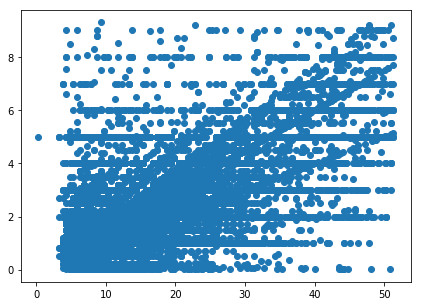

In [130]:
plt.figure(figsize=(7,5))
plt.plot(x.iloc[:,0], y, 'o')

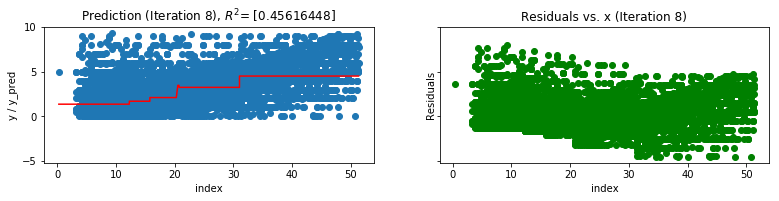

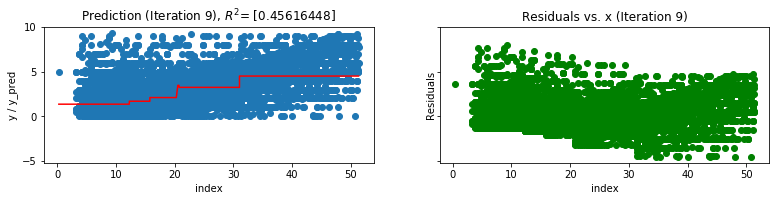

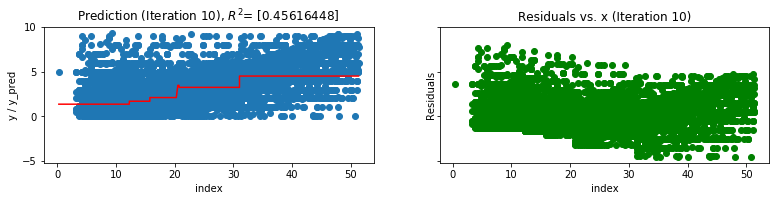

In [131]:
bt = ExecutionGB(x,y,estimator_numbers = 10)

- Although after 8th iteration, residuals are seemed to be not randomly distributed around 0 and the predictions are close to true values until 45%.

## GB using a trip distance

In [132]:
x = pd.DataFrame({'trip_distance':(df['trip_distance'].reset_index())['trip_distance'] })
y = (df['tip_amount'].values)
y = y[:,None]

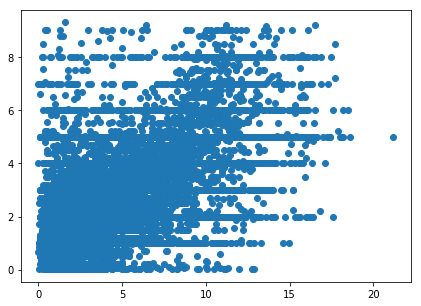

In [133]:
plt.figure(figsize=(7,5))
plt.plot(x.iloc[:,0],y, 'o')

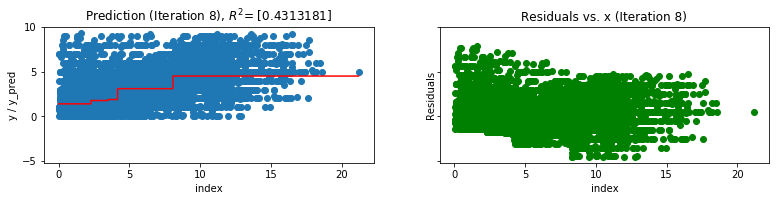

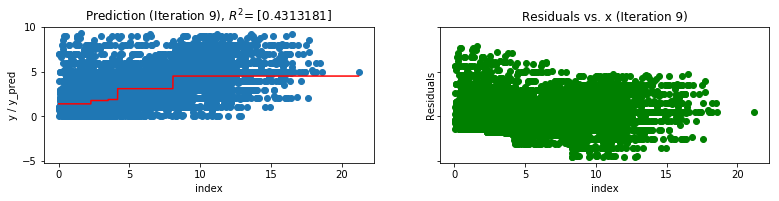

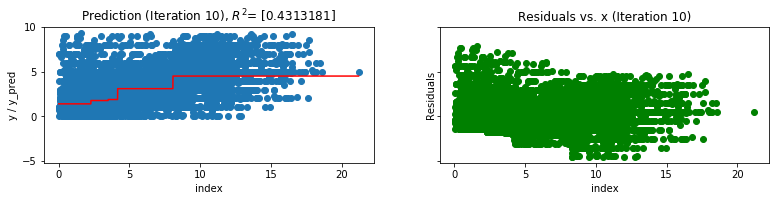

In [134]:
td = ExecutionGB(x,y,estimator_numbers = 10)

- Although after 8th iteration, residuals are seemed to be not randomly distributed around 0 and the predictions are close to true values until 45%. 

## GB using a trip distance and an amount of a trip cost before tipping

In [135]:
x = pd.DataFrame({'before_tip':(df['before_tip'].reset_index())['before_tip'],
                 'trip_distance':(df['trip_distance'].reset_index())['trip_distance'] })

y = (df['tip_amount'].values)
y = y[:,None]

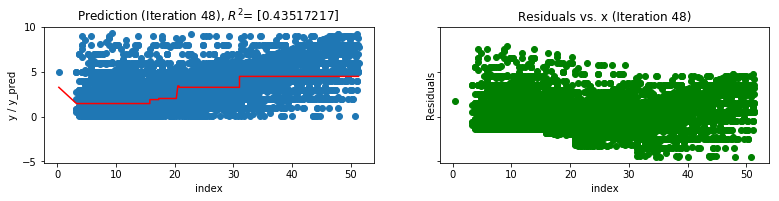

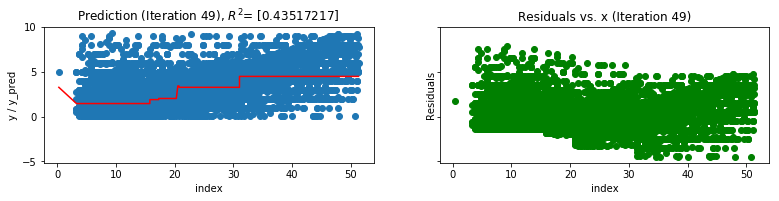

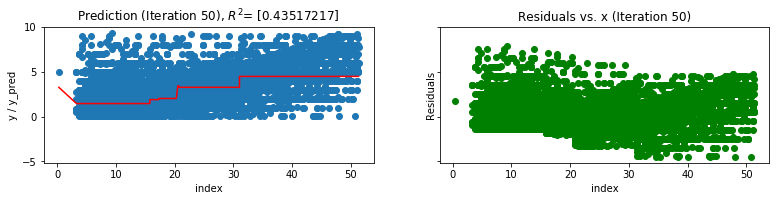

In [137]:
bttd = ExecutionGB(x,y,estimator_numbers = 50)

## Conclusion

- The amount of a trip cost before tipping variable is more able to explain the tip amount than the trip distance and with it.
- However, the GB model using an amount of a trip cost before tipping has a more than half of variance and the distribution of residuals do not present a random distribution. 
- Maybe if a iteration number is sufficiently higher (although my CPU could not support it) the residual distribution would be normaly.